<a href="https://colab.research.google.com/github/sipocz/Zindi_plastic/blob/main/Image_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import ee
import geemap
import PIL
import pandas
from google.colab import drive

In [62]:
_DEBUG_=False
_PROJECT_IMAGE_BASE_='/content/drive/MyDrive/Zindi_Plastic_images_RGB/'
_IMAGES_='images'
_PROJECT_FILES_BASE_='/content/drive/MyDrive/Zindi_Plastic_images/'
_TEST_IMAGES_='test_images'

_ORIG_='orig'


In [24]:
ee.Authenticate()
ee.Initialize(project='zindiplasticproject')
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
def add_time(image):
  return image.addBands(image.getNumber('system:time_start'))

In [26]:
def conditional(image):
  return ee.Algorithms.If(
      ee.Number(image.get('SUN_ELEVATION')).gt(40), image, ee.Image(0)
  )


In [27]:
def gamma_correct(gamma, path):
    """

    Args:
      gamma: selected gamma value
      path: the path of the image

    Returns: gamma corrected image

    """
    im = PIL.Image.open(path)
    gamma1 = gamma
    row = im.size[0]
    col = im.size[1]
    result_img1 = PIL.Image.new(mode="RGB", size=(row, col), color=0)
    for x in range(row):
        for y in range(col):
            r = pow(im.getpixel((x, y))[0] / 255, (1 / gamma1)) * 255
            g = pow(im.getpixel((x, y))[1] / 255, (1 / gamma1)) * 255
            b = pow(im.getpixel((x, y))[2] / 255, (1 / gamma1)) * 255
            # add
            color = (int(r), int(g), int(b))
            result_img1.putpixel((x, y), color)
    #show
    return result_img1

In [28]:
def image_download(index=int,longitude=float,latitude=float,place=str,sat=None,band=None,sdate="2024-04-15",edate="2024-04-17"):
    from math import gamma
    import geemap
    import ee

    # Google Earth Engine inicializálása
    ee.Initialize()

    if sat==None:
        sat='COPERNICUS/S2_SR_HARMONIZED'
    if band==None:
        band=['TCI_R','TCI_G','TCI_B']

    # 1000 méteres körzet létrehozása Budapest középpontjában
    point = ee.Geometry.Point([longitude, latitude])
    buffer = point.buffer(10).bounds()  # 1000 méteres buffer

    # Sentinel-2 műholdkép lekérése nappali időszakban
    collection = ee.ImageCollection(sat) \
        .filterBounds(buffer) \
        .filterDate(sdate, edate) \
        .sort('CLOUDY_PIXEL_PERCENTAGE')  # Legkevésbé felhős kép kiválasztása
    first_image = collection.first()  # Az első legkevésbé felhős kép

    # Ellenőrizd, hogy az első kép érvényes
    if first_image is None:
        raise ValueError("Nem találtunk érvényes képet a megadott időszakban.")

    # Kép RGB sávok kiválasztása
    image = first_image.select(band)  # Red, Green, Blue
    import matplotlib.pyplot as plt

    aoi=ee.Geometry.Rectangle(longitude-0.005,latitude-0.005,longitude+0.005,latitude+0.005 )


    rgb_img = geemap.ee_to_numpy(image,region=aoi)
    if _DEBUG_==True:
        print(rgb_img.shape)

    max_p=15448 #rgb_img[:,:,2].max()

    rgb_img_test = (255 * ((rgb_img[:, :, 0:3] ) / 255)).astype("uint8")

    if _DEBUG_==True:
        print(rgb_img[:,:,2].max())


    img=PIL.Image.fromarray(rgb_img_test)

    img=img.resize((192,192))
    return img


In [29]:
_DEBUG_=True

In [30]:
pil_image=image_download(20,37.05635887,0.053674338,"Kenya",sat="COPERNICUS/S2_SR_HARMONIZED",band=['TCI_R','TCI_G','TCI_B'],sdate="2024-04-14",edate="2024-05-04")

(111, 112, 3)
255


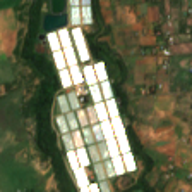

In [31]:
pil_image

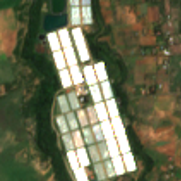

In [32]:
pil_image.crop((0,0,181,181))


In [33]:
image_download(20,37.05635887,0.053674338,"Kenya")

Exception: Image.select: Parameter 'input' is required.

In [34]:

df_kenya=pandas.read_csv(_PROJECT_FILES_BASE_+_ORIG_+"/Kenya_training.csv")


In [35]:
df_kenya.head()

,ID,lon,lat,blue_p50,green_p50,nir_p50,nira_p50,re1_p50,re2_p50,re3_p50,red_p50,swir1_p50,swir2_p50,VV_p50,VH_p50,TARGET
0,1,37.059054,0.046039,2731.0,3035.0,5418.0,5306.5,2958.0,4610.5,5099.5,2994.0,4108.5,3187.5,-6.861458,-12.162713,1
1,2,37.059503,0.047296,2921.0,3329.0,5834.0,6472.0,4144.5,5782.0,6302.0,3344.0,5269.0,4471.5,-8.082717,-14.619608,1
2,3,37.057527,0.047656,3828.0,4163.0,6420.0,7890.5,5408.5,6695.5,7302.0,4380.0,6905.0,6905.5,-7.767043,-14.880353,1
3,4,37.057976,0.047925,2556.0,2839.0,4822.0,5276.5,3201.0,4643.0,5069.5,2787.0,3832.0,2867.5,-7.773118,-15.587653,1
4,5,37.056359,0.048554,3790.0,4009.0,6476.0,6199.5,4285.0,5711.0,6079.5,3939.0,4892.5,3702.5,-6.104467,-15.431915,1


In [36]:
def image_generation(df,image_id):
    for i,row in df.iterrows():
        image=image_download(row.ID,row.lon,row.lat,image_id,sat=_sat_,band=_band_,sdate="2024-04-14",edate="2024-05-04")
        image.save(_PROJECT_IMAGE_BASE_+_IMAGES_+"/"+str(int(row.ID))+'_'+str(int(row.TARGET))+"_"+image_id+".jpg")
        print(str(i).rjust(3,'0'),end=".")
        if i % 20==0:
            print("*")

In [37]:
_sat_=None
_band_=None
_image_id_="kenya"

In [38]:
image_generation(df_kenya,_image_id_)

(112, 112, 3)
255
000.*
(112, 112, 3)
255
001.(112, 112, 3)
255
002.(112, 112, 3)
255
003.(112, 112, 3)
255
004.(112, 112, 3)
255
005.(112, 112, 3)
255
006.(112, 112, 3)
255
007.(112, 112, 3)
255
008.(112, 112, 3)
255
009.(112, 112, 3)
255
010.(112, 112, 3)
255
011.(112, 112, 3)
255
012.(112, 112, 3)
255
013.(112, 112, 3)
255
014.(112, 112, 3)
255
015.(112, 112, 3)
255
016.(111, 112, 3)
255
017.(111, 112, 3)
255
018.(111, 112, 3)
255
019.(111, 112, 3)
255
020.*
(111, 112, 3)
255
021.(111, 112, 3)
255
022.(111, 112, 3)
255
023.(111, 112, 3)
255
024.(111, 112, 3)
255
025.(112, 112, 3)
255
026.(112, 112, 3)
178
027.(112, 112, 3)
178
028.(112, 112, 3)
178
029.(112, 112, 3)
178
030.(112, 112, 3)
178
031.(112, 112, 3)
178
032.(111, 112, 3)
178
033.(111, 112, 3)
178
034.(111, 112, 3)
178
035.(111, 112, 3)
178
036.(111, 112, 3)
178
037.(111, 112, 3)
224
038.(111, 112, 3)
224
039.(111, 112, 3)
224
040.*
(111, 112, 3)
224
041.(111, 112, 3)
191
042.(111, 112, 3)
209
043.(111, 112, 3)
193
044.(111

In [39]:
df_spain=pandas.read_csv(_PROJECT_FILES_BASE_+_ORIG_+"/Spain_training.csv")
_image_id_="spain"

In [40]:
image_generation(df_spain,_image_id_)

(112, 91, 3)
255
000.*
(112, 90, 3)
255
001.(112, 91, 3)
255
002.(113, 91, 3)
255
003.(113, 91, 3)
255
004.(113, 91, 3)
255
005.(113, 90, 3)
255
006.(112, 91, 3)
255
007.(112, 92, 3)
255
008.(113, 92, 3)
255
009.(112, 90, 3)
255
010.(112, 91, 3)
255
011.(112, 91, 3)
255
012.(112, 90, 3)
255
013.(113, 90, 3)
255
014.(112, 90, 3)
255
015.(113, 92, 3)
255
016.(113, 92, 3)
255
017.(112, 91, 3)
255
018.(113, 92, 3)
255
019.(112, 90, 3)
255
020.*
(112, 90, 3)
255
021.(112, 90, 3)
255
022.(112, 91, 3)
255
023.(112, 90, 3)
255
024.(113, 90, 3)
255
025.(112, 91, 3)
255
026.(112, 90, 3)
255
027.(112, 90, 3)
255
028.(112, 90, 3)
255
029.(113, 91, 3)
255
030.(112, 90, 3)
255
031.(113, 90, 3)
255
032.(113, 91, 3)
255
033.(113, 91, 3)
255
034.(112, 91, 3)
255
035.(112, 90, 3)
255
036.(112, 90, 3)
255
037.(112, 91, 3)
255
038.(112, 91, 3)
255
039.(112, 91, 3)
255
040.*
(112, 90, 3)
255
041.(112, 91, 3)
255
042.(112, 91, 3)
255
043.(112, 90, 3)
255
044.(113, 91, 3)
255
045.(112, 91, 3)
255
046.(112, 9

In [41]:
df_vnm=pandas.read_csv(_PROJECT_FILES_BASE_+_ORIG_+"/VNM_training.csv")
_image_id_="vnm"

In [42]:
df_vnm.head()

,ID,Lon,Lat,blue_p50,green_p50,nir_p50,nira_p50,re1_p50,re2_p50,re3_p50,red_p50,swir1_p50,swir2_p50,VV_p50,VH_p50,TARGET
0,1,108.307403,11.706890,1772.5,2081.5,4393.0,4322.0,2542.0,3974.5,4315.0,1901.5,2929.5,2324.0,-5.506588,-16.577070,1
1,2,108.363279,11.778036,2178.0,2347.0,3427.0,3712.0,2658.5,3358.0,3628.5,2313.0,3122.0,2729.5,-7.798610,-14.007271,1
2,3,108.193946,11.689462,2927.0,3107.0,4365.0,4624.5,3378.0,4221.5,4508.5,3082.0,3921.0,3190.0,-7.652615,-14.319975,1
3,4,108.200324,11.691618,2175.0,2312.0,3472.5,3613.5,2569.5,3332.0,3558.5,2244.0,3132.5,2610.0,-9.530750,-16.471949,1
4,5,108.203109,11.694313,2125.0,2235.0,2612.0,2960.0,2548.5,2801.0,2908.0,2320.0,2915.0,2685.5,-9.733130,-18.106146,1


In [43]:
df_vnm['lon']=df_vnm["Lon"]
df_vnm['lat']=df_vnm["Lat"]

In [44]:
image_generation(df_vnm,_image_id_)

(113, 112, 3)
255
000.*
(113, 111, 3)
255
001.(113, 112, 3)
255
002.(112, 111, 3)
255
003.(113, 111, 3)
255
004.(113, 111, 3)
250
005.(113, 111, 3)
227
006.(113, 111, 3)
201
007.(113, 111, 3)
255
008.(113, 111, 3)
201
009.(114, 111, 3)
179
010.(113, 111, 3)
172
011.(113, 112, 3)
211
012.(113, 111, 3)
211
013.(114, 111, 3)
255
014.(113, 111, 3)
255
015.(113, 112, 3)
248
016.(113, 111, 3)
255
017.(113, 112, 3)
255
018.(113, 111, 3)
255
019.(113, 112, 3)
255
020.*
(114, 111, 3)
246
021.(113, 112, 3)
255
022.(113, 112, 3)
255
023.(113, 111, 3)
255
024.(113, 112, 3)
211
025.(113, 111, 3)
198
026.(113, 112, 3)
255
027.(113, 112, 3)
255
028.(113, 111, 3)
255
029.(114, 112, 3)
255
030.(113, 111, 3)
255
031.(113, 112, 3)
255
032.(113, 111, 3)
252
033.(113, 111, 3)
255
034.(113, 112, 3)
255
035.(113, 112, 3)
255
036.(113, 111, 3)
255
037.(113, 111, 3)
252
038.(113, 111, 3)
255
039.(113, 112, 3)
255
040.*
(113, 112, 3)
255
041.(113, 112, 3)
255
042.(113, 111, 3)
255
043.(114, 111, 3)
255
044.(113

In [45]:
df_vnm.head()

,ID,Lon,Lat,blue_p50,green_p50,nir_p50,nira_p50,re1_p50,re2_p50,re3_p50,red_p50,swir1_p50,swir2_p50,VV_p50,VH_p50,TARGET,lon,lat
0,1,108.307403,11.706890,1772.5,2081.5,4393.0,4322.0,2542.0,3974.5,4315.0,1901.5,2929.5,2324.0,-5.506588,-16.577070,1,108.307403,11.706890
1,2,108.363279,11.778036,2178.0,2347.0,3427.0,3712.0,2658.5,3358.0,3628.5,2313.0,3122.0,2729.5,-7.798610,-14.007271,1,108.363279,11.778036
2,3,108.193946,11.689462,2927.0,3107.0,4365.0,4624.5,3378.0,4221.5,4508.5,3082.0,3921.0,3190.0,-7.652615,-14.319975,1,108.193946,11.689462
3,4,108.200324,11.691618,2175.0,2312.0,3472.5,3613.5,2569.5,3332.0,3558.5,2244.0,3132.5,2610.0,-9.530750,-16.471949,1,108.200324,11.691618
4,5,108.203109,11.694313,2125.0,2235.0,2612.0,2960.0,2548.5,2801.0,2908.0,2320.0,2915.0,2685.5,-9.733130,-18.106146,1,108.203109,11.694313


In [46]:
df_spain_test=pandas.read_csv(_PROJECT_FILES_BASE_+_ORIG_+"/Spain_validation.csv")
_image_id_="_spain_testing"
_sat_=None
_band_=None
df_spain_test["TARGET"]=0

In [47]:
image_generation(df_spain_test,_image_id_)


(113, 91, 3)
255
000.*
(112, 91, 3)
255
001.(113, 90, 3)
255
002.(113, 90, 3)
255
003.(112, 91, 3)
255
004.(113, 92, 3)
255
005.(113, 92, 3)
255
006.(113, 91, 3)
255
007.(112, 91, 3)
255
008.(112, 91, 3)
255
009.(112, 91, 3)
255
010.(113, 90, 3)
255
011.(112, 91, 3)
255
012.(112, 90, 3)
255
013.(113, 90, 3)
255
014.(112, 91, 3)
255
015.(113, 92, 3)
255
016.(113, 91, 3)
255
017.(113, 91, 3)
255
018.(112, 90, 3)
255
019.(112, 90, 3)
255
020.*
(112, 90, 3)
255
021.(111, 90, 3)
255
022.(112, 91, 3)
255
023.(112, 90, 3)
255
024.(112, 90, 3)
255
025.(112, 90, 3)
255
026.(112, 90, 3)
255
027.(112, 90, 3)
255
028.(112, 91, 3)
255
029.(112, 90, 3)
255
030.(112, 91, 3)
255
031.(113, 91, 3)
255
032.(113, 91, 3)
255
033.(113, 91, 3)
255
034.(113, 91, 3)
255
035.(112, 91, 3)
255
036.(113, 91, 3)
255
037.(112, 90, 3)
255
038.(112, 91, 3)
255
039.(112, 90, 3)
255
040.*
(112, 91, 3)
255
041.(112, 90, 3)
255
042.(112, 91, 3)
255
043.(113, 90, 3)
255
044.(113, 91, 3)
255
045.(112, 91, 3)
255
046.(112, 9

In [48]:
df_vnm_test=pandas.read_csv(_PROJECT_FILES_BASE_+_ORIG_+"/VNM_testing.csv")
_image_id_="_vnm_testing"
_sat_=None
_band_=None
df_vnm_test["TARGET"]=0
df_vnm_test["lon"]=df_vnm_test["Lon"]
df_vnm_test["lat"]=df_vnm_test["Lat"]

In [49]:
df_vnm_test.head()


,ID,Lon,Lat,blue_p50,green_p50,nir_p50,nira_p50,re1_p50,re2_p50,re3_p50,red_p50,swir1_p50,swir2_p50,VV_p50,VH_p50,TARGET,lon,lat
0,1,108.406667,11.699973,2284.0,2429.0,2857.0,3314.5,2690.5,3043.5,3165.0,2461.0,3385.5,2848.0,-9.688691,-17.492636,0,108.406667,11.699973
1,2,108.364087,11.780641,2606.0,2743.0,3708.0,4164.0,3226.5,3826.5,4080.5,2819.0,3978.5,3402.0,-8.679594,-16.148212,0,108.364087,11.780641
2,3,108.201133,11.690091,1965.0,2174.0,3713.0,3767.0,2475.5,3473.5,3750.5,2050.0,2870.5,2309.0,-7.793950,-14.815912,0,108.201133,11.690091
3,4,108.196731,11.692157,2010.0,2051.0,2401.0,2510.0,2234.0,2448.0,2532.0,2106.0,2476.5,2137.0,-9.485932,-15.773308,0,108.196731,11.692157
4,5,108.197809,11.695032,2084.0,2253.0,3148.0,3371.0,2628.0,3212.5,3369.0,2301.0,3226.0,2874.0,-7.751073,-16.848070,0,108.197809,11.695032


In [50]:
image_generation(df_vnm_test,_image_id_)

(113, 111, 3)
255
000.*
(113, 112, 3)
255
001.(113, 111, 3)
255
002.(113, 112, 3)
255
003.(113, 111, 3)
255
004.(113, 111, 3)
250
005.(113, 111, 3)
255
006.(113, 111, 3)
201
007.(113, 111, 3)
179
008.(114, 111, 3)
255
009.(114, 111, 3)
255
010.(113, 111, 3)
173
011.(113, 112, 3)
173
012.(113, 111, 3)
211
013.(113, 111, 3)
255
014.(113, 112, 3)
248
015.(113, 111, 3)
255
016.(113, 111, 3)
255
017.(114, 111, 3)
255
018.(113, 112, 3)
237
019.(114, 112, 3)
255
020.*
(113, 111, 3)
255
021.(113, 111, 3)
255
022.(113, 111, 3)
255
023.(113, 111, 3)
251
024.(113, 111, 3)
255
025.(114, 112, 3)
255
026.(113, 111, 3)
255
027.(113, 111, 3)
255
028.(113, 112, 3)
255
029.(113, 112, 3)
238
030.(113, 112, 3)
255
031.(113, 111, 3)
255
032.(113, 112, 3)
255
033.(113, 112, 3)
255
034.(113, 111, 3)
255
035.(113, 111, 3)
255
036.(113, 112, 3)
255
037.(113, 112, 3)
255
038.(113, 111, 3)
255
039.(113, 112, 3)
255
040.*
(113, 112, 3)
255
041.(113, 112, 3)
255
042.(113, 112, 3)
255
043.(113, 112, 3)
255
044.(113

In [51]:
df_kenya_test=pandas.read_csv(_PROJECT_FILES_BASE_+_ORIG_+"/Kenya_testing.csv")
_image_id_="_kenya_testing"
_sat_=None
_band_=None
df_kenya_test["TARGET"]=0


In [52]:
image_generation(df_kenya_test,_image_id_)

(112, 112, 3)
255
000.*
(112, 112, 3)
255
001.(112, 112, 3)
255
002.(112, 112, 3)
255
003.(112, 112, 3)
255
004.(112, 112, 3)
255
005.(112, 112, 3)
255
006.(112, 112, 3)
255
007.(112, 112, 3)
255
008.(112, 112, 3)
255
009.(112, 112, 3)
255
010.(112, 112, 3)
255
011.(112, 112, 3)
255
012.(112, 112, 3)
255
013.(112, 112, 3)
255
014.(112, 112, 3)
255
015.(111, 112, 3)
255
016.(111, 112, 3)
255
017.(111, 112, 3)
255
018.(111, 112, 3)
255
019.(111, 112, 3)
255
020.*
(111, 112, 3)
255
021.(111, 112, 3)
255
022.(111, 112, 3)
255
023.(111, 112, 3)
255
024.(112, 112, 3)
255
025.(112, 112, 3)
178
026.(112, 112, 3)
178
027.(112, 112, 3)
178
028.(112, 112, 3)
178
029.(112, 112, 3)
178
030.(111, 112, 3)
178
031.(111, 112, 3)
178
032.(111, 112, 3)
178
033.(111, 112, 3)
178
034.(111, 112, 3)
178
035.(111, 112, 3)
178
036.(111, 112, 3)
178
037.(111, 112, 3)
191
038.(111, 112, 3)
224
039.(111, 112, 3)
204
040.*
(111, 112, 3)
209
041.(111, 112, 3)
191
042.(111, 112, 3)
255
043.(112, 112, 3)
255
044.(112

In [53]:

# _sat_="LANDSAT/LC08/C02/T1_L2"
# _band_=['SR_B7','SR_B3','SR_B2']
# _image_id_="_kenya_landsat"

In [54]:
# image_generation(df_kenya,_image_id_)

In [55]:
def format_image(image_dir):
    image = tf.read_file(image_dir)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize_image_with_pad(image, 256, 256, align_corners=True)
    return image

In [63]:
test_images_dir=_PROJECT_IMAGE_BASE_+_TEST_IMAGES_
images_dir=_PROJECT_IMAGE_BASE_+_IMAGES_

In [65]:
print(images_dir)

/content/drive/MyDrive/Zindi_Plastic_images_RGB/images


In [69]:
!mkdir  {images_dir+'/plastic'}
!mkdir  {images_dir+'/non_plastic'}

mkdir: cannot create directory ‘/content/drive/MyDrive/Zindi_Plastic_images_RGB/images/plastic’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/Zindi_Plastic_images_RGB/images/non_plastic’: File exists


In [70]:
!mv {images_dir+'/*_1_*.jpg'} {images_dir+'/plastic'}
!mv {images_dir+'/*_2_*.jpg'} {images_dir+'/non_plastic'}

In [71]:
!mv {images_dir+'/*_0_*.jpg'} {test_images_dir}

mv: cannot stat '/content/drive/MyDrive/Zindi_Plastic_images_RGB/images/*_0_*.jpg': No such file or directory


In [59]:
# END of Image generation

In [60]:
stop here the map download

SyntaxError: invalid syntax (<ipython-input-60-3e98966d834a>, line 1)